# Mean climate evaluation

This analysis compares the mean climate of downscaled and parent models to observations. It doesn't consider extremes (i.e. the tails of the distribution aren't considered).

In [1]:
import glob
import calendar

import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from geocat.viz import TaylorDiagram
import cmocean

import spatial_selection

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/geocat/viz/cmaps.py:9: DeprecationWarning: geocat.viz.cmaps is deprecated, use cmaps instead
  warnings.warn("geocat.viz.cmaps is deprecated, use cmaps instead",


In [2]:
dask.diagnostics.ProgressBar().register()

In [3]:
start_date = '1995-01-01'
end_date = '2014-12-31'

In [4]:
nrm_clusters = gp.read_file('/g/data/xv83/dbi599/shapefiles/NRM_clusters/NRM_clusters.shp')
nrm_clusters

,OBJECTID,Shape_Leng,Shape_Area,code,label,geometry
0,1,43.872364,28.309947,CS,Central Slopes,"POLYGON ((147.95551 -24.87828, 147.95583 -24.8..."
1,2,56.117544,34.176299,EC,East Coast,"POLYGON ((150.74778 -22.17931, 150.75589 -22.2..."
2,4,45.869349,45.299310,MB,Murray Basin,"POLYGON ((145.74766 -32.21733, 145.75055 -32.2..."
3,5,119.284033,124.655757,MN,Monsoonal North,"MULTIPOLYGON (((119.10713 -19.52547, 119.10875..."
4,6,137.457553,407.116072,R,Rangelands,"MULTIPOLYGON (((118.80797 -20.07215, 118.80600..."
5,7,59.887218,23.431035,SS,Southern Slopes,"MULTIPOLYGON (((144.35074 -40.52507, 144.34898..."
6,8,87.137068,50.647491,SSWF,Southern and South-Western Flatlands,"MULTIPOLYGON (((137.24178 -36.44855, 137.23945..."
7,9,45.896712,19.503388,WT,Wet Tropics,"MULTIPOLYGON (((148.82846 -19.98136, 148.88120..."


/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


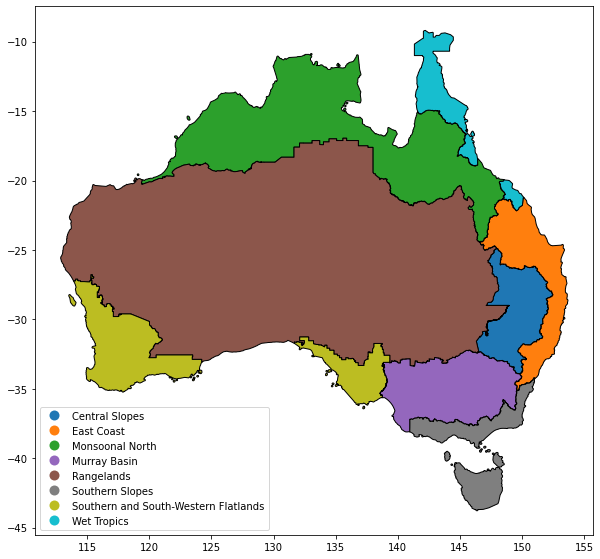

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nrm_clusters.plot(
    ax=ax,
    column='label',
    legend=True,
    edgecolor='black',
    legend_kwds={'loc': 'lower left'}    
)
plt.show()

In [6]:
nrm_sub_clusters = gp.read_file('/g/data/xv83/dbi599/shapefiles/NRM_sub_clusters/NRM_sub_clusters.shp')
nrm_sub_clusters

,OBJECTID,C_code,C_Label,code,label,geometry
0,9,WT,Wet Tropics,WT,Wet Tropics,"MULTIPOLYGON (((150.17258 -21.24859, 150.09178..."
1,0,R,Rangelands,RN,Rangelands (North),"MULTIPOLYGON (((118.80797 -20.07215, 118.80600..."
2,0,MN,Monsoonal North,MNE,Monsoonal North (East),"POLYGON ((146.42400 -18.40860, 146.44167 -18.4..."
3,0,MN,Monsoonal North,MNW,Monsoonal North (West),"MULTIPOLYGON (((133.03730 -10.85283, 133.03836..."
4,0,EC,East Coast,ECS,East Coast (South),"POLYGON ((151.03053 -34.27589, 151.03053 -34.2..."
5,0,CS,Central Slopes,CS,Central Slopes,"POLYGON ((147.95700 -24.87855, 147.95711 -24.8..."
6,0,MB,Murray Basin,MB,Murray Basin,"MULTIPOLYGON (((140.96606 -38.10852, 140.96606..."
7,0,SSWF,Southern and South Western Flatlands,SSWFW,Southern and South Western Flatlands (West),"MULTIPOLYGON (((121.99574 -34.52416, 121.99376..."
8,0,SSWF,Southern and South Western Flatlands,SSWFE,Southern and South Western Flatlands (East),"MULTIPOLYGON (((137.32870 -36.29796, 137.32916..."
9,0,SS,Southern Slopes,SSVE,Southern Slopes (Vic/NSW East),"MULTIPOLYGON (((147.09424 -39.19847, 147.06241..."


/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


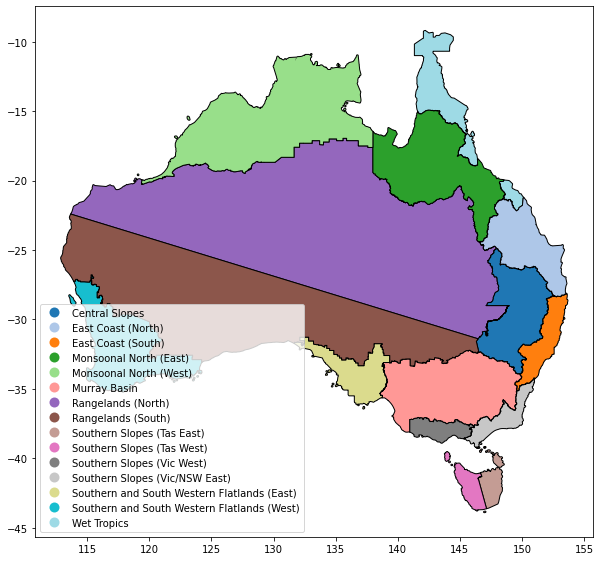

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nrm_sub_clusters.plot(
    ax=ax,
    column='label',
    legend=True,
    edgecolor='black',
    cmap='tab20',
    legend_kwds={'loc': 'lower left'}    
)
plt.show()

In [8]:
aus_shape = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')

## Get NorESM2-MM data

In [47]:
noresm_dates = ['19900101-19991231', '20000101-20091231', '20100101-20141231']
noresm_pr_files = [f'/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_{dates}.nc' for dates in noresm_dates]
noresm_pr_files

['/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_19900101-19991231.nc',
 '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_20000101-20091231.nc',
 '/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-MM/historical/r1i1p1f1/day/pr/gn/v20191108/pr_day_NorESM2-MM_historical_r1i1p1f1_gn_20100101-20141231.nc']

In [48]:
noresm_ds = xr.open_mfdataset(noresm_pr_files)
noresm_ds = noresm_ds.sel({'time': slice(start_date, end_date)})

In [49]:
noresm_ds

<xarray.Dataset>
Dimensions:    (time: 7300, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 1995-01-01 12:00:00 ... 2014-12-31 12:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(1825, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(1825, 192, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(1825, 288, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(1825, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1200-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     438000.0
    ...                        ...
    title:                     NorESM2-MM output prepared for CMIP6
    variable_id:               pr
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/f7744e3e-b098-4d86-8acf-5903b3f3bf9f

In [50]:
noresm_ds['pr'] = noresm_ds['pr'] * 86400
noresm_ds['pr'].attrs['units'] = 'mm' 

In [51]:
noresm_annual_totals = noresm_ds.resample({'time': 'A'}).sum('time', keep_attrs=True)
noresm_annual_clim = noresm_annual_totals.mean('time', keep_attrs=True)
noresm_monthly_totals = noresm_ds.resample({'time': 'M'}).sum('time', keep_attrs=True)
noresm_monthly_clim = noresm_monthly_totals.groupby('time.month').mean('time', keep_attrs=True)

## Get AGCD data

In [14]:
agcd_years = np.arange(1995, 2015, 1)
agcd_pr_files = [f'/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_{year}.nc' for year in agcd_years]
agcd_pr_files

['/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1995.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1996.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1997.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1998.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1999.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2000.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2001.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2002.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2003.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_2004.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthl

In [15]:
agcd_ds = xr.open_mfdataset(agcd_pr_files)
agcd_ds = agcd_ds.sel({'time': slice(start_date, end_date)})

In [16]:
agcd_ds

<xarray.Dataset>
Dimensions:    (time: 240, lat: 691, lon: 886, nv: 2)
Coordinates:
  * time       (time) datetime64[ns] 1995-01-16 ... 2014-12-16
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
Dimensions without coordinates: nv
Data variables:
    lat_bnds   (time, lat, nv) float32 dask.array<chunksize=(12, 691, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nv) float32 dask.array<chunksize=(12, 886, 2), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    precip     (time, lat, lon) float32 dask.array<chunksize=(12, 691, 886), meta=np.ndarray>
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
Attributes: (12/33)
    geospatial_lat_min:        -44.525
    geospatial_lat_max:        -9.975
    geospatial_lon_min:        111.975
    geospatial_lon_max:        156.275
    time_coverage_start:       1995-01-01T00:00:00
    date_created:              2020-08-28T20:49:40.578734
    ...                        ...
    licence:                   Data Licence: The grid data files in this AGCD...
    description:               This AGCD data is a snapshot of the operationa...
    date_issued:               2020-12-14 00:36:44
    attribution:               Data should be cited as : Australian Bureau of...
    copyright:                 (C) Copyright Commonwealth of Australia 2020, ...
    history:

In [17]:
agcd_annual_totals = agcd_ds.resample({'time': 'A'}).sum('time', keep_attrs=True)
agcd_annual_clim = agcd_annual_totals.mean('time', keep_attrs=True)
agcd_monthly_clim = agcd_ds.groupby('time.month').mean('time', keep_attrs=True)

In [18]:
agcd_annual_clim = spatial_selection.select_shapefile_regions(agcd_annual_clim, aus_shape)

[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  4.9s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  3.4s


In [19]:
agcd_monthly_clim = spatial_selection.select_shapefile_regions(agcd_monthly_clim, aus_shape)

[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  1.1s
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed |  3.6s


In [52]:
noresm_regridder = xe.Regridder(noresm_ds, agcd_ds, "bilinear")

In [53]:
noresm_annual_clim = noresm_regridder(noresm_annual_clim)
noresm_monthly_clim = noresm_regridder(noresm_monthly_clim)

In [54]:
noresm_annual_clim = spatial_selection.select_shapefile_regions(noresm_annual_clim, aus_shape)

[########################################] | 100% Completed | 11.7s
[########################################] | 100% Completed | 10.8s


In [55]:
noresm_monthly_clim = spatial_selection.select_shapefile_regions(noresm_monthly_clim, aus_shape)

[########################################] | 100% Completed | 11.7s
[########################################] | 100% Completed | 11.7s


## Mean bias

In [56]:
noresm_annual_clim = noresm_annual_clim.compute()

[########################################] | 100% Completed | 10.7s


In [57]:
agcd_annual_clim = agcd_annual_clim.compute()

In [58]:
noresm_annual_clim

<xarray.Dataset>
Dimensions:  (lat: 656, lon: 814)
Coordinates:
  * lon      (lon) float32 112.9 113.0 113.1 113.1 ... 153.4 153.5 153.6 153.6
  * lat      (lat) float32 -43.6 -43.55 -43.5 -43.45 ... -10.2 -10.15 -10.1
Data variables:
    pr       (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    regrid_method:  bilinear

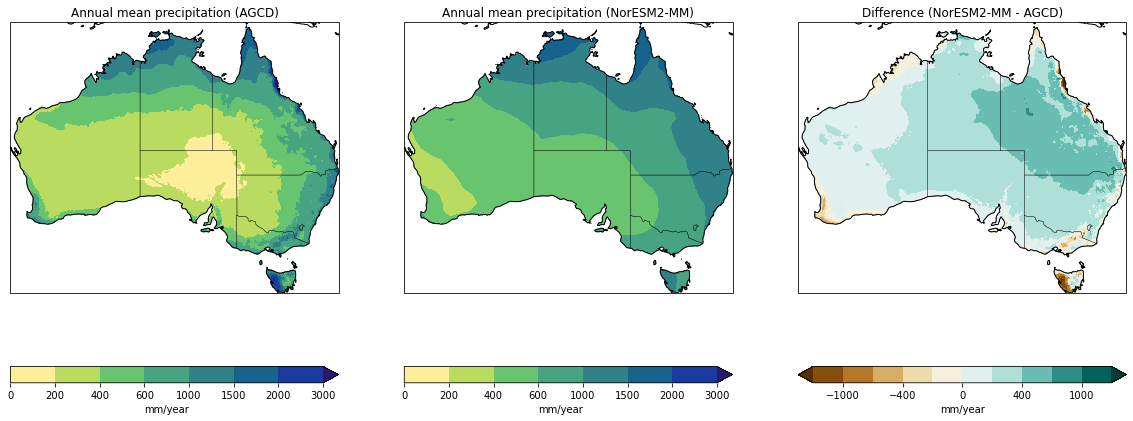

In [59]:
fig = plt.figure(figsize=[20, 9])

noresm_max = np.nanmax(noresm_annual_clim['pr'].values)
agcd_max = np.nanmax(agcd_annual_clim['precip'].values)
vmax = np.nanmax([noresm_max, agcd_max])

noresm_min = np.nanmin(noresm_annual_clim['pr'].values)
agcd_min = np.nanmin(agcd_annual_clim['precip'].values)
vmin = np.nanmin([noresm_min, agcd_min])

levels = [0, 200, 400, 600, 1000, 1500, 2000, 3000]

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
agcd_annual_clim['precip'].plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.haline_r,
    levels=levels,
    extend='max',
    cbar_kwargs = {'orientation': 'horizontal', 'label': 'mm/year'}
)
ax1.set_title('Annual mean precipitation (AGCD)')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
noresm_annual_clim['pr'].plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=cmocean.cm.haline_r,
    levels=levels,
    extend='max',
    cbar_kwargs = {'orientation': 'horizontal', 'label': 'mm/year'}
)
ax2.set_title('Annual mean precipitation (NorESM2-MM)')

diff = noresm_annual_clim['pr'] - agcd_annual_clim['precip']
ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
diff.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap='BrBG',
    levels=[-1500, -1000, -600, -400, -200, 0, 200, 400, 600, 1000, 1500],
    extend='both',
    cbar_kwargs = {'orientation': 'horizontal', 'label': 'mm/year'}
)
ax3.set_title('Difference (NorESM2-MM - AGCD)')

for ax in [ax1, ax2, ax3]:
    #ax.add_geometries(nrm_shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black')
    ax.coastlines()
    ax.add_feature(cartopy.feature.STATES, linewidth=0.3)
    #ax.spines['top'].set_visible(False)

#plt.suptitle(title)
plt.show()

## Temporal 

In [60]:
noresm_monthly_clim = noresm_monthly_clim.compute()

[########################################] | 100% Completed | 11.7s


In [61]:
agcd_monthly_clim = agcd_monthly_clim.compute()

In [62]:
temporal_corr = xr.corr(noresm_monthly_clim['pr'], agcd_monthly_clim['precip'], dim='month') 

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [63]:
noresm_temporal_std = noresm_monthly_clim['pr'].std(dim='month', keep_attrs=True)
agcd_temporal_std = agcd_monthly_clim['precip'].std(dim='month', keep_attrs=True)
std_ratio = noresm_temporal_std / agcd_temporal_std

/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xv83/dbi599/miniconda3/envs/model-eval/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


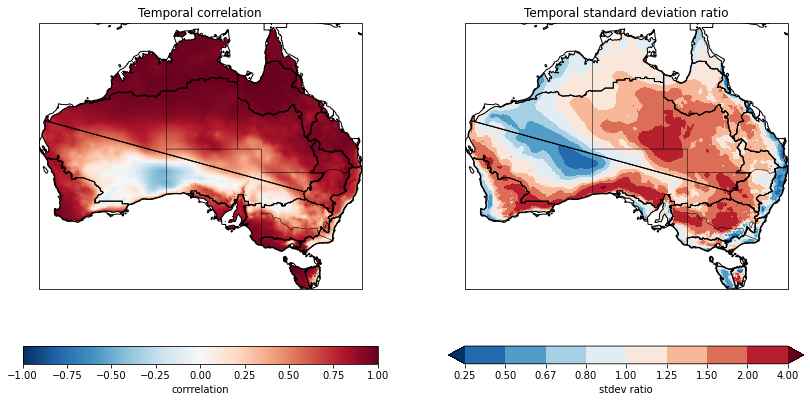

In [64]:
fig = plt.figure(figsize=[14, 7])

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
temporal_corr.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmax=1,
    vmin=-1,
    cbar_kwargs = {'orientation': 'horizontal', 'label': 'corrrelation'}
)
ax1.set_title('Temporal correlation')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
std_ratio.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    levels=[0.25, 0.5, 0.67, 0.8, 1.0, 1.25, 1.5, 2.0, 4.0],
    extend='both',
    cbar_kwargs = {'orientation': 'horizontal', 'label': 'stdev ratio'}
)
ax2.set_title('Temporal standard deviation ratio')

for ax in [ax1, ax2]:
    ax.coastlines()
    ax.add_geometries(nrm_sub_clusters.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black')
    ax.add_feature(cartopy.feature.STATES, linewidth=0.3)
#plt.suptitle(title)
plt.show()

In [65]:
noresm_monthly_clim_nrm_sub_clusters = spatial_selection.select_shapefile_regions(
noresm_monthly_clim,
    nrm_sub_clusters,
    agg='weighted_mean',
    header='label'
)
noresm_monthly_clim_nrm_sub_clusters

<xarray.Dataset>
Dimensions:  (month: 12, region: 15)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region   (region) <U43 'Wet Tropics' ... 'Rangelands (South)'
Data variables:
    pr       (month, region) float64 302.4 111.5 262.0 ... 63.54 134.3 33.75
Attributes:
    regrid_method:  bilinear

In [66]:
agcd_monthly_clim_nrm_sub_clusters = spatial_selection.select_shapefile_regions(
    agcd_monthly_clim,
    nrm_sub_clusters,
    agg='weighted_mean',
    header='label'
)
agcd_monthly_clim_nrm_sub_clusters

<xarray.Dataset>
Dimensions:   (month: 12, region: 15, nv: 2)
Coordinates:
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region    (region) <U43 'Wet Tropics' ... 'Rangelands (South)'
Dimensions without coordinates: nv
Data variables:
    lat_bnds  (month, nv, region) float32 -14.93 -23.66 -19.19 ... -24.62 -28.78
    lon_bnds  (month, nv, region) float32 143.8 133.8 143.1 ... 150.1 127.1
    precip    (month, region) float32 358.1 68.34 198.2 ... 119.9 112.2 25.51
    crs       (month, region) float64 -2.147e+09 -2.147e+09 ... -2.147e+09
Attributes: (12/33)
    geospatial_lat_min:        -44.525
    geospatial_lat_max:        -9.975
    geospatial_lon_min:        111.975
    geospatial_lon_max:        156.275
    time_coverage_start:       1995-01-01T00:00:00
    date_created:              2020-08-28T20:49:40.578734
    ...                        ...
    licence:                   Data Licence: The grid data files in this AGCD...
    description:               This AGCD data is a snapshot of the operationa...
    date_issued:               2020-12-14 00:36:44
    attribution:               Data should be cited as : Australian Bureau of...
    copyright:                 (C) Copyright Commonwealth of Australia 2020, ...
    history:

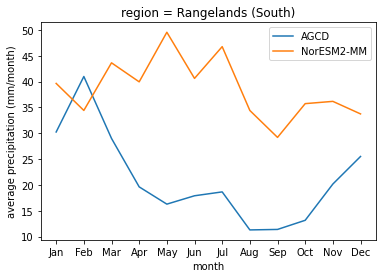

In [67]:
agcd_monthly_clim_nrm_sub_clusters['precip'].sel({'region': 'Rangelands (South)'}).plot(label='AGCD')
noresm_monthly_clim_nrm_sub_clusters['pr'].sel({'region': 'Rangelands (South)'}).plot(label='NorESM2-MM')
xticks = np.arange(1,13)
xlabels = [calendar.month_abbr[i] for i in xticks]
plt.xticks(xticks, xlabels)
plt.legend()
plt.ylabel('average precipitation (mm/month)')
plt.show()

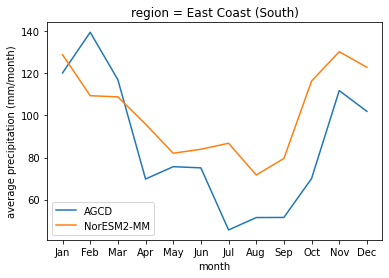

In [68]:
agcd_monthly_clim_nrm_sub_clusters['precip'].sel({'region': 'East Coast (South)'}).plot(label='AGCD')
noresm_monthly_clim_nrm_sub_clusters['pr'].sel({'region': 'East Coast (South)'}).plot(label='NorESM2-MM')
xticks = np.arange(1,13)
xlabels = [calendar.month_abbr[i] for i in xticks]
plt.xticks(xticks, xlabels)
plt.legend()
plt.ylabel('average precipitation (mm/month)')
plt.show()

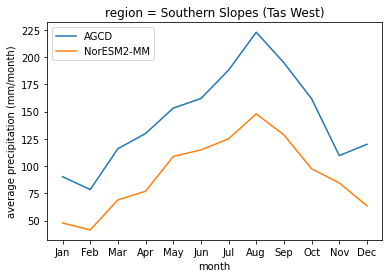

In [69]:
agcd_monthly_clim_nrm_sub_clusters['precip'].sel({'region': 'Southern Slopes (Tas West)'}).plot(label='AGCD')
noresm_monthly_clim_nrm_sub_clusters['pr'].sel({'region': 'Southern Slopes (Tas West)'}).plot(label='NorESM2-MM')
xticks = np.arange(1,13)
xlabels = [calendar.month_abbr[i] for i in xticks]
plt.xticks(xticks, xlabels)
plt.legend()
plt.ylabel('average precipitation (mm/month)')
plt.show()

## Spatial

In [70]:
noresm_spatial_corr = xr.corr(noresm_monthly_clim['pr'], agcd_monthly_clim['precip'], dim=['lat', 'lon']) 

In [71]:
noresm_spatial_corr

<xarray.DataArray (month: 12)>
array([0.92219578, 0.85821769, 0.88564255, 0.78255632, 0.76415333,
       0.78248587, 0.77447214, 0.75545701, 0.69661913, 0.6568549 ,
       0.84540615, 0.87765893])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [72]:
noresm_spatial_corr_ave = float(noresm_spatial_corr.mean('month'))
noresm_spatial_corr_ave

0.8001433174227296

In [73]:
noresm_spatial_std = noresm_monthly_clim['pr'].std(dim=['lat', 'lon'], keep_attrs=True)
noresm_spatial_std

<xarray.DataArray 'pr' (month: 12)>
array([91.18102419, 84.86626678, 64.19514499, 26.13781665, 14.00270763,
       20.24258759, 22.00753276, 22.41993854, 22.78897695, 25.31933385,
       38.59903154, 60.53564745])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [74]:
noresm_spatial_std_ave = float(noresm_spatial_std.mean('month'))
noresm_spatial_std_ave

41.02466741121325

In [75]:
agcd_spatial_std = agcd_monthly_clim['precip'].std(dim=['lat', 'lon'], keep_attrs=True)
agcd_spatial_std

<xarray.DataArray 'precip' (month: 12)>
array([86.03025 , 83.350334, 65.742355, 27.680489, 21.766886, 25.258516,
       26.000431, 27.653423, 24.398739, 20.887032, 27.361084, 55.231556],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    cell_methods:           time: sum time: sum (interval : 1 day)
    units:                  mm
    long_name:              Daily precipitation
    standard_name:          lwe_thickness_of_precipitation_amount
    frequency:              monthly
    start_offset:           -24
    grid_mapping:           crs
    coverage_content_type:  physicalMeasurement
    valid_range:            [     0. 100000.]

In [76]:
agcd_spatial_std_ave = float(agcd_spatial_std.mean('month'))
agcd_spatial_std_ave

40.94675827026367

In [77]:
noresm_spatial_std_ratio = noresm_spatial_std_ave / agcd_spatial_std_ave
noresm_spatial_std_ratio

1.001902693747704

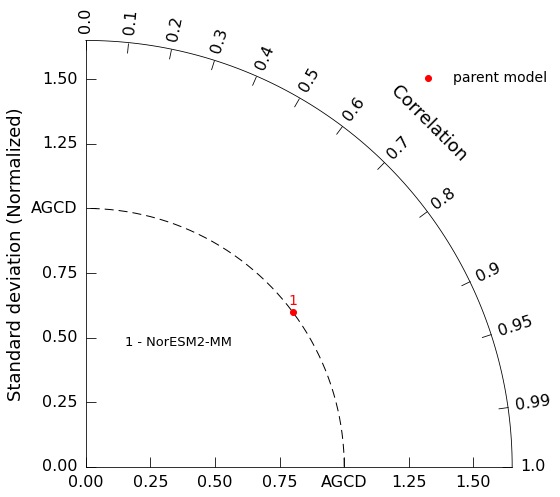

In [78]:
# parent models
parent_std_ratios = [noresm_spatial_std_ratio]
parent_corrs = [noresm_spatial_corr_ave]

# CCAM data
ccam_std_ratios = []
ccam_corrs = []

# BARPA data
barpa_std_ratios = []
barpa_corrs = []

# Create figure and TaylorDiagram instance
fig = plt.figure(figsize=(8, 8))
dia = TaylorDiagram(fig=fig, label='AGCD')

# Add parent models to Taylor diagram
dia.add_model_set(
    parent_std_ratios,
    parent_corrs,
    color='red',
    marker='o',
    label='parent model'
)

namearr = ['NorESM2-MM']
dia.add_model_name(namearr)
dia.add_legend()
plt.show()